In [1]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots, Printf
using Plots.PlotMeasures
include("plotting.jl")
include("petrels.jl")
include("grouse.jl")
include("shasta1.jl")
include("shasta2.jl")
include("batchHPPCACompletion.jl")

updatev! (generic function with 1 method)

### Batch vs. Streaming on missing data: Static subspace

In [2]:
# d, n, v, λ = 50, [200,800], [1,4], [4,2,1]
# d, n, v, λ = 50, [200,800], [0.1,1], [4,2,1]
# d, n, v, λ = 50, [200,800], [1e-4,1e-2], [4,2,1]

# d, n, v, λ = 100, [500,2000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 100, [2500,10000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 100, [3000,12000], [1e-4,1e-2], [4,2,1]
d, n, v, λ = 100, [3000,12000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 50, [500,2000], [1e-2,1e-2], [4,2,1]

# d, n, v, λ = 50, [100,1000], [1e-2,1], [4,2,1]
k, L = length(λ), length(v)
khat = k;

num_trials = 1

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.5
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ytrue[l] for l in 1:L]

### Streaming-setup
Ymat_true = hcat([Ytrue[l] for l=1:L]...)
Ymat = hcat([Y[l] for l=1:L]...)
vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
ΩY = abs.(Ymat) .> 0

dataIdx = randperm(sum(n))
Ymat = Ymat[:,dataIdx]
Ymat_true = Ymat_true[:,dataIdx]
ΩY = ΩY[:,dataIdx]
groups = groups[dataIdx]

### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

Ltrue = loglikelihood(Mtrue,Ytrue)
stats_fcn(M) = loglikelihood(M,Ytrue) - Ltrue

stats_fcn (generic function with 1 method)

In [3]:
function Fmeasure(M)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

Fmeasure (generic function with 1 method)

In [4]:
### HePPCAT (Batch)
heppcat_time_log = []
for _=1:1
    tHeppcat = @elapsed begin
        Mheppcat = heppcat(Y,k,100) 
    end
    push!(heppcat_time_log,tHeppcat)
end
tHeppcat = median(heppcat_time_log)
Mheppcat = heppcat(Y,k,100) 

### Homoscedastic PPCA
cor = sum(Y[l]*Y[l]' for l in 1:L)/sum(n)
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))

HePPCATModel{Float64, Float64}([-0.14121386502194283 0.03889802424985226 0.10543597244119098; -0.15253282635112392 -0.045101510576532694 0.06697970484483572; … ; -0.12061561133009047 0.0039810844638149545 -0.1170529661625837; -0.14639407791399278 -0.07692741525378198 0.10565434396783732], [1.011884159677905, 0.5024420216504129, 0.2491282384971866], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.021404306427152946, 0.021404306427152946])

In [5]:
# stats_fcn(M) = M.v

##### Batch algorithm

In [6]:
include("batchHPPCACompletion.jl")

updatev! (generic function with 1 method)

In [7]:
batch_stats_trials = []
batch_err_trials = []
batch_time_trials = []
batch_models = []
niters = 50

Mbatch = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,1,Fmeasure,stats_fcn)

Random.seed!(0)
for _=1:num_trials
    Mbatch = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,niters,Fmeasure,stats_fcn)
    push!(batch_stats_trials,batch_stats_log)
    push!(batch_err_trials,batch_err_log)
    push!(batch_time_trials,batch_time_log)
    push!(batch_models,Mbatch)
end

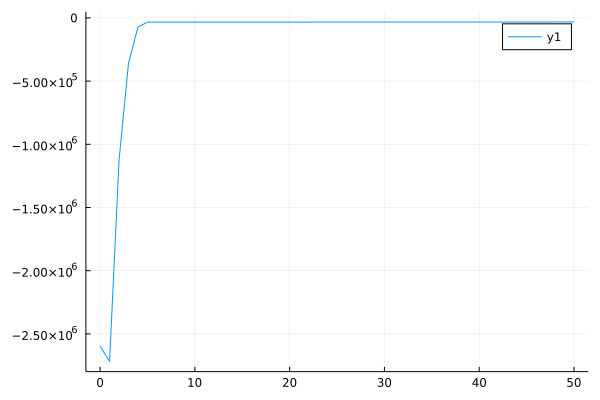

In [8]:
plot(0:length(batch_stats_trials...)-1,batch_stats_trials)

##### SHASTA-PCA-2

In [15]:
mutable struct LearningRateParams
    w::Float64
    cf::Float64
    cv::Float64
end

In [16]:
shasta_stats_trials = []
shasta_err_trials = []
shasta_time_trials = []
shasta_models = []

# w = 0.001
w = 1
cf = 1
# cv = 0.5
cv = 1
δ = 0.1


lrparams = LearningRateParams(w,cf,cv)


Yrec = deepcopy(Ymat)

### Compile the function on a dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream = deepcopy(M0)
Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA2(Mstream,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn)

Random.seed!(0)
for _=1:num_trials
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA2(Mstream,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn)
    push!(shasta_stats_trials,stats_log)
    push!(shasta_err_trials,err_log)
    push!(shasta_time_trials,time_log)
    push!(shasta_models,Mstream)
end

##### SHASTA-PCA-1

In [17]:
shasta2_stats_trials = []
shasta2_err_trials = []
shasta2_time_trials = []
shasta2_models = []

# w = 0.001
w = 1
cf = 1
cv = 1
Yrec = deepcopy(Ymat)

δ = 0.1

lrparams = LearningRateParams(w,cf,cv)

### Compile the function on a dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream2 = deepcopy(M0)
Mstream2, Yrec2, stats_log2, err_log2, time_log2 = SHASTA_PCA1(Mstream2,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn)

Random.seed!(0)
for _=1:num_trials
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
#     M0 = HePPCATModel(U,λ,I(k),rand(L))
    Mstream2 = deepcopy(M0)
    Mstream2, Yrec2, stats_log2, err_log2, time_log2 = SHASTA_PCA1(Mstream2,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn)
    push!(shasta2_stats_trials,stats_log2)
    push!(shasta2_err_trials,err_log2)
    push!(shasta2_time_trials,time_log2)
    push!(shasta2_models,Mstream2)
end

In [27]:
include("plotting.jl")

plottimetraces (generic function with 3 methods)

In [28]:
stats = [shasta2_stats_trials,shasta_stats_trials,batch_stats_trials]
errs = [shasta2_err_trials,shasta_err_trials,batch_err_trials]
times = [shasta2_time_trials,shasta_time_trials,batch_time_trials]
labels = ["SHASTA-PCA-1","SHASTA-PCA-2","Batch method"]
colors = Dict("SHASTA-PCA-1"=>:lightblue,"SHASTA-PCA-2"=>:blue,"Batch method"=>:black)
markers = Dict("SHASTA-PCA-1"=>:circ,"SHASTA-PCA-2"=>:diamond,"Batch method"=>:rect)
interval = Dict("SHASTA-PCA-1"=>1000,"SHASTA-PCA-2"=>1000,"Batch method"=>1)

Dict{String, Int64} with 3 entries:
  "SHASTA-PCA-1" => 1000
  "SHASTA-PCA-2" => 1000
  "Batch method" => 1

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/kgilman/.julia/packages/Plots/CBYO0/src/axes.jl:76


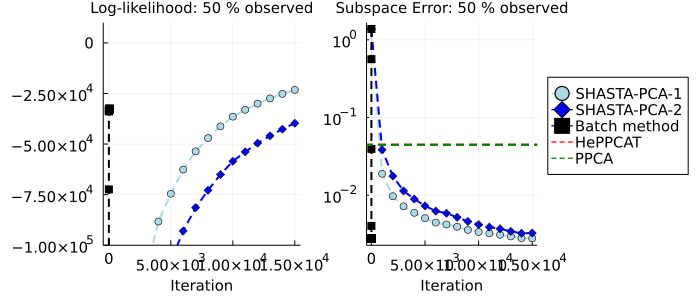

In [29]:
missing_rate = Int(round((1-missing)*100))
# interval = [1000, 1]
alpha = 0.05
fontsize = 10
figsize = (400,300)

p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,"Subspace Error: $missing_rate % observed","Iteration",:outerright,:log)
hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

figsize = (400,300)
# colors = Dict("SHASTA-PCA-2"=>:blue)
p2 = plottraces(stats,labels,colors,markers,interval,alpha,figsize,fontsize,"Log-likelihood: $missing_rate % observed","Iteration",false,:linear)
hline!(p2,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p2,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

ylims!(p2,(-1e5,1e4))
p = plot(p2,p1,layout = @layout([q1{0.38w} q2]),size=(700,300),bottom_margin=5mm)
# p = plot(p1,p2,layout = @layout([q1{0.5w} q2]),size=(800,300),bottom_margin=5mm)

# file = "shasta_results/online_algs_iteration-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p,file)
plot(p)

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/kgilman/.julia/packages/Plots/CBYO0/src/axes.jl:76


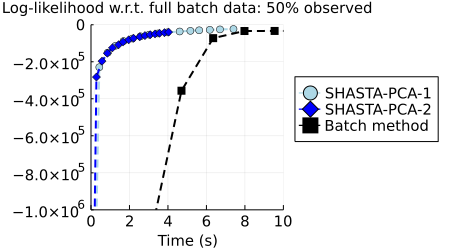

In [30]:
missing_rate = Int(round((1-missing)*100))
p1 = plottimetraces(stats,times,labels,colors,markers,interval,alpha,figsize,fontsize,"Log-likelihood w.r.t. full batch data: $missing_rate% observed","Time (s)",:outerright)
# hline!(p1,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p1,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")
xlims!(0,10)
ylims!(-1e6,0)
plot!(size=(450,250))
file = "/Users/kgilman/Desktop/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/batch_log-likelihood-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p1,file)
plot(p1)

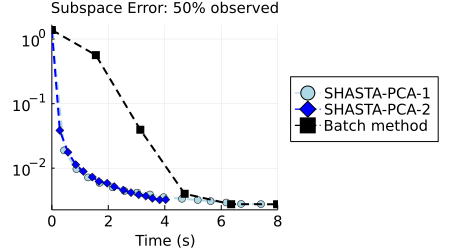

In [31]:
missing_rate = Int(round((1-missing)*100))
p1 = plottimetraces(errs,times,labels,colors,markers,interval,alpha,figsize,fontsize,"Subspace Error: $missing_rate% observed","Time (s)",:outerright,:log)
# hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")
xlims!(0,8)
plot!(size=(450,250))
file = "/Users/kgilman/Desktop/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/batch_subspace-distance-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p1,file)
plot(p1)

In [ ]:
Mstream.v

In [ ]:
Mstream2.v

In [ ]:
Mbatch.v

In [ ]:
abs.(Mstream.v - Mtrue.v) ./ Mtrue.v

In [ ]:
abs.(Mstream2.v - Mtrue.v) ./ Mtrue.v